# Extract e-features from current clamp voltage responses

Author: Darshan Mandge, Open Brain Institute

Copyright (c) 2025 Open Brain Institute

This notebook demonstrates how to load electrophysiology data using h5py for eFEL eFeatures extraction.

In [1]:
import efel
import numpy as np
import h5py
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 10

We will use the voltage trace recordings obtained from the recording file C291001A2-MT-C1.nwb. The traces come electrophysiological patch clamp slice recordings of a bSTUT eleectrical firing type (e-type) cell of rat isocortex. The file can be obtained by visiting the Electrophysiology Data page

The dataset contains one distribution of the traces in NWB file format.

The nwb is present [here](https://openbraininstitute.sharepoint.com/:u:/s/OBI-Scientificstaff/Eb8FqyQL2rdGnhd4kMu1MyoBdG8HtnAkDCL_Mfx4Y1H7gQ?e=UWZWSh) in OneDrive location: `OBI -> Scientific staff ->Documents -> Data -> ephys`. 

Download the folder with the file and put it here `./Cellular/efeature_extraction`

In [2]:
test_data = "../ephys/C291001A2-MT-C1.nwb" # data file should be replaced with file downloaded from the link or a direct link to the file

# Read the data
data = h5py.File(test_data, 'r')

# Find the keys in the nwb data
data.keys()

<KeysViewHDF5 ['acquisition', 'analysis', 'data_organization', 'file_create_date', 'general', 'identifier', 'processing', 'session_description', 'session_start_time', 'specifications', 'stimulus', 'timestamps_reference_time']>

In [3]:
# find the entries in the acquisition group
data["acquisition"].keys()

<KeysViewHDF5 ['ccs__ADHPdepol__139', 'ccs__ADHPhyperpol__140', 'ccs__ADHPhyperpol__179', 'ccs__ADHPhyperpol__180', 'ccs__ADHPhyperpol__181', 'ccs__ADHPhyperpol__182', 'ccs__ADHPrest__141', 'ccs__APDrop__142', 'ccs__APThreshold__010', 'ccs__APThreshold__011', 'ccs__APThreshold__012', 'ccs__APWaveform__058', 'ccs__APWaveform__059', 'ccs__APWaveform__060', 'ccs__APWaveform__061', 'ccs__APWaveform__062', 'ccs__APWaveform__063', 'ccs__APWaveform__064', 'ccs__APWaveform__065', 'ccs__APWaveform__066', 'ccs__APWaveform__067', 'ccs__APWaveform__068', 'ccs__APWaveform__069', 'ccs__APWaveform__070', 'ccs__APWaveform__071', 'ccs__APWaveform__072', 'ccs__APWaveform__073', 'ccs__APWaveform__074', 'ccs__APWaveform__075', 'ccs__C1_HP_1sec__190', 'ccs__C1_HP_1sec__191', 'ccs__C1_HP_1sec__192', 'ccs__C1_HP_1sec__193', 'ccs__C1_HP_1sec__194', 'ccs__C1_HP_1sec__195', 'ccs__C1_HP_1sec__196', 'ccs__C1_HP_1sec__197', 'ccs__C1_HP_1sec__198', 'ccs__C1_HP_1sec__199', 'ccs__C1_HP_1sec__200', 'ccs__C1_HP_1sec__2

Select the trace from acquisition that you want to plot, covert the data to numpy arrays and plot them

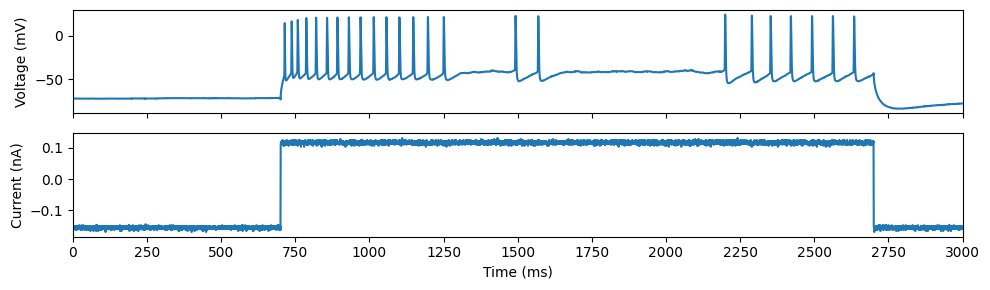

In [4]:

trace_name = "ccs__IDRest__131"
voltage = data["acquisition"][trace_name]["data"]
current_trace_name = trace_name.replace("ccs_", "ccss_")
current = data["stimulus"]["presentation"][current_trace_name]["data"]

v_array = np.array(
            voltage * voltage.attrs["conversion"], dtype="float32"
        ) * 1e3 # convert to mV
i_array = np.array(
    current[()] * current.attrs["conversion"], dtype="float32"
) * 1e9 # convert to nA

start_time = data["stimulus"]["presentation"][current_trace_name]["starting_time"]
dt = 1. / float(start_time.attrs["rate"])

t_array = np.arange(0, len(v_array)) * dt * 1000 # multiply by 1000 to convert to ms

# create a subplot with shared x axis to plot the voltage and current traces
fig, axs = plt.subplots(nrows = 2, ncols=1, figsize=(10,3) ,sharex=True)
axs[0].plot(t_array, v_array)
axs[0].set_ylabel("Voltage (mV)")
axs[1].plot(t_array, i_array)
axs[1].set_ylabel("Current (nA)")
axs[1].set_xlabel("Time (ms)")
axs[1].set_xlim(0, t_array[-1])
axs[1].set_xticks(np.arange(0, t_array[-1] + 1, 250)) # set xticks at every 250 ms
plt.tight_layout()
plt.show()

The current clamp starts around 700 ms and ends near 2700 ms. We will use these values to extract features from the voltage trace using eFEL.

Let's create a `trace` dictionary to extract features from voltage trace show above.

In [5]:
stim_start = 700
stim_end = 2700
trace = {"T": t_array, "V": v_array, "stim_start": [stim_start], "stim_end": [stim_end]}

We can now use the eFEL to extract e-feature values from the trace shown above.

We will use the ``get_feature_values()`` function, which accepts a list of trace and the requested eFeature names as input.

Let's extract some burst-related features. We should also set some eFEL settings for accurate detection of spikes using the
`efel.set_setting()` function.

e.g. it is advised to set `strict_stiminterval` as `True` for most features if you want to extract them within stimulus duration

In [6]:
 # To calcualte feaatures within duration of stimulus
efel.set_setting("strict_stiminterval", True) 

# Settings for burst detection
efel.set_setting("ignore_first_ISI", False) # Don't ignore the first spike
efel.set_setting("strict_burst_factor", 4.0) # The burst detection can be fine-tuned by changing the setting strict_burst_factor. Default value is 2.0.
feature_values = efel.get_feature_values([trace], ['voltage_base', 'spikes_per_burst', 'strict_burst_number', 'strict_burst_mean_freq', 'peak_time', 'AP_height', 'peak_indices', 'burst_begin_indices', 'burst_end_indices'])[0]
feature_values

{'voltage_base': array([-71.69862732]),
 'spikes_per_burst': array([15,  7]),
 'strict_burst_number': array([2]),
 'strict_burst_mean_freq': array([27.94857462, 16.09935603]),
 'peak_time': array([ 714.3,  737.8,  758.3,  787.2,  820.3,  857. ,  892. ,  930.5,
         970. , 1014.5, 1057.5, 1101. , 1147.8, 1197.3, 1251. , 1492.8,
        1569.5, 2199.7, 2289.7, 2353. , 2421.3, 2492.7, 2563. , 2634.5]),
 'AP_height': array([14.06181393, 16.24295807, 18.0741188 , 20.1177681 , 20.43025513,
        20.53025055, 20.93647766, 21.09272003, 21.12397003, 21.3114624 ,
        21.21771431, 21.06147194, 21.21146698, 21.31145973, 21.43645477,
        22.69264374, 22.405159  , 23.87383728, 23.08012352, 22.56140136,
        22.29266167, 22.35515899, 22.56140136, 22.09267424]),
 'peak_indices': array([ 7143,  7378,  7583,  7872,  8203,  8570,  8920,  9305,  9700,
        10145, 10575, 11010, 11478, 11973, 12510, 14928, 15695, 21997,
        22897, 23530, 24213, 24927, 25630, 26345]),
 'burst_begin_in

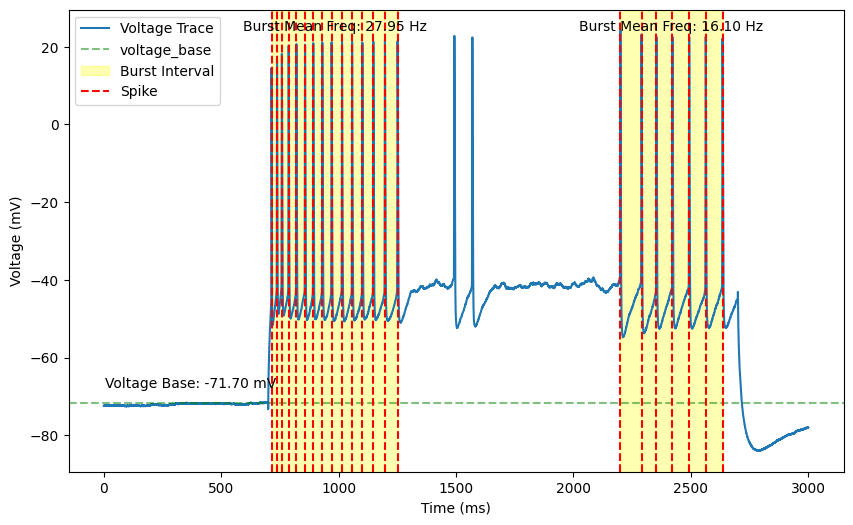

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_array, v_array, label='Voltage Trace')

# plot the voltage_base feature as a horizontal dashed line 
ax.axhline(y=feature_values['voltage_base'], color='green', 
           linestyle='--', alpha=0.5, label='voltage_base')

ax.text(x = t_array[25], y=feature_values['voltage_base']+5, 
        s=f'Voltage Base: {feature_values["voltage_base"][0]:.2f} mV', 
        verticalalignment='center', color='black')


for i in range(0,len(feature_values["burst_begin_indices"])):
    burst_begin_indices = feature_values['burst_begin_indices'][i]
    burst_end_indices = feature_values['burst_end_indices'][i]
    peak_times = feature_values['peak_time']
    ap_heights = feature_values['AP_height']
    burst_mean_freq = feature_values['strict_burst_mean_freq']

    time_spike_indices = np.where((t_array > stim_start) & (t_array < stim_end))
    time_spike = t_array[time_spike_indices]
    voltage_spike = v_array[time_spike_indices]



    burst_start = peak_times[burst_begin_indices]
    burst_end = peak_times[burst_end_indices]
    mean_frequency = burst_mean_freq[i]

    ax.axvspan(burst_start, burst_end, color='yellow', alpha=0.3, label='Burst Interval')

    for spike_time in peak_times[burst_begin_indices:burst_end_indices+1]:
        ax.axvline(x=spike_time, color='red', linestyle='--', label='Spike' if 'Spike' not in plt.gca().get_legend_handles_labels()[1] else "")

    ax.text((burst_start + burst_end) / 2, max(voltage_spike), f'Burst Mean Freq: {mean_frequency:.2f} Hz', horizontalalignment='center', color='black')

    if i == 0:
        ax.legend()
    # show only till 1400 ms
    # plt.xlim(0, 1400)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.show()

We can save the feature values obtained from `get_feature_values` for later use. Two functions, `save_feature_values_to_json` and `save_feature_values_to_csv`, are provided for this purpose. They save the feature values as a JSON file and a CSV file, respectively.

In [8]:
# efel.io.save_feature_to_json(feature_values, 'output.json')
# efel.io.save_feature_to_csv(feature_values, 'output.csv')

Let's calculate some subthreshold features. The trace `ccs__IV__022` is a hyperpolarising step response. See belwo

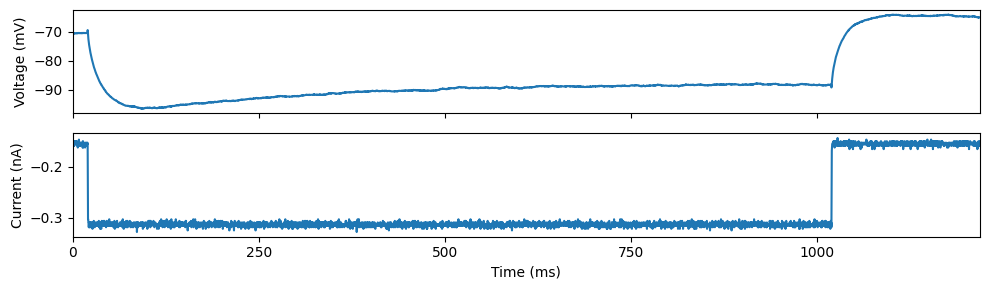

In [9]:
trace_name = "ccs__IV__022"
voltage = data["acquisition"][trace_name]["data"]
current_trace_name = trace_name.replace("ccs_", "ccss_")
current = data["stimulus"]["presentation"][current_trace_name]["data"]

v_array = np.array(
            voltage * voltage.attrs["conversion"], dtype="float32"
        ) * 1e3 # convert to mV
i_array = np.array(
    current[()] * current.attrs["conversion"], dtype="float32"
) * 1e9 # convert to nA

start_time = data["stimulus"]["presentation"][current_trace_name]["starting_time"]
dt = 1. / float(start_time.attrs["rate"])

t_array = np.arange(0, len(v_array)) * dt * 1000 # multiply by 1000 to convert to ms

# create a subplot with shared x axis to plot the voltage and current traces
fig, axs = plt.subplots(nrows = 2, ncols=1, figsize=(10,3) ,sharex=True)
axs[0].plot(t_array, v_array)
axs[0].set_ylabel("Voltage (mV)")
axs[1].plot(t_array, i_array)
axs[1].set_ylabel("Current (nA)")
axs[1].set_xlabel("Time (ms)")
axs[1].set_xlim(0, t_array[-1])
axs[1].set_xticks(np.arange(0, t_array[-1] + 1, 250)) # set xticks at every 250 ms
plt.tight_layout()
plt.show()


Getting stim_start and stim_end for the traces is important for accurate calculation of features. If you don't know these values you can find it teractively e.g. using plotly

In [45]:
## ! pip install plotly nbformat
# from plotly import graph_objects as go
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=t_array, y=i_array, mode='lines', name='Current Trace'))
# fig.update_layout(title='Current Trace',
#                      xaxis_title='Time (ms)',
#                      yaxis_title='Current (nA)')

Let's extract `voltage_base`, `steady_state_voltage_stimend`and `minimum_voltage` features.

In [15]:
stim_start = 20
stim_end = 1020
trace = {"T": t_array, "V": v_array, "stim_start": [stim_start], "stim_end": [stim_end]}

# To reset efel
efel.reset()

# to set strict_stiminterval to True
efel.set_setting("strict_stiminterval", True) 

feature_values = efel.get_feature_values([trace], ['voltage_base', 'steady_state_voltage_stimend', 'minimum_voltage'])[0]
feature_values

{'voltage_base': array([-70.26438698]),
 'steady_state_voltage_stimend': array([-88.17279293]),
 'minimum_voltage': array([-96.49530029])}

Let's plot these voltage traces and the feature values

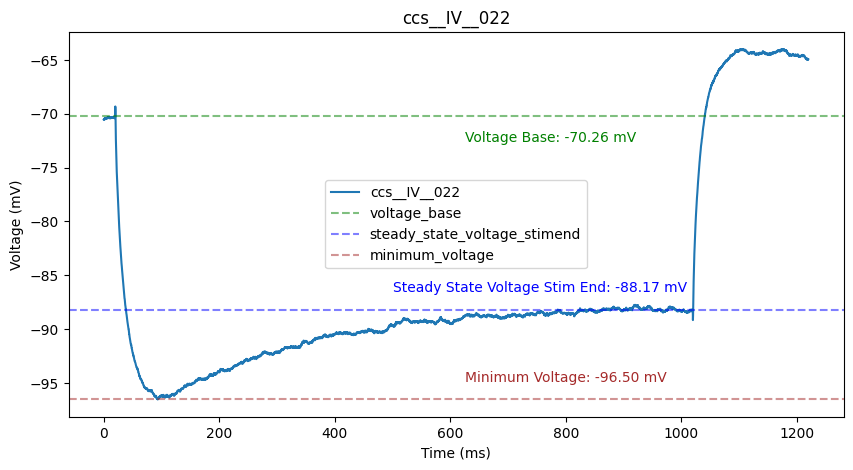

In [44]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t_array, v_array, label=trace_name)
# plot the voltage_base feature as a horizontal dashed line
ax.axhline(y=feature_values['voltage_base'], color='green', 
           linestyle='--', alpha=0.5, label='voltage_base')

ax.text(x = t_array[2500], y=feature_values['voltage_base']-2,
        s=f'Voltage Base: {feature_values["voltage_base"][0]:.2f} mV', 
        verticalalignment='center', color='green')


#plot the steady_state_voltage_stimend feature as a horizontal dashed line
ax.axhline(y=feature_values['steady_state_voltage_stimend'], color='blue', 
           linestyle='--', alpha=0.5, label='steady_state_voltage_stimend')

ax.text(x = t_array[2000], y=feature_values['steady_state_voltage_stimend']+2,
        s=f'Steady State Voltage Stim End: {feature_values["steady_state_voltage_stimend"][0]:.2f} mV', 
        verticalalignment='center', color='blue')


# plot the minimum voltage as a horizontal dashed line
ax.axhline(y=feature_values['minimum_voltage'], color='brown', 
           linestyle='--', alpha=0.5, label='minimum_voltage')

ax.text(x = t_array[2500], y=feature_values['minimum_voltage']+2,
        s=f'Minimum Voltage: {feature_values["minimum_voltage"][0]:.2f} mV', 
        verticalalignment='center', color='brown')

ax.legend()
plt.title(trace_name)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.show()
